## Multivariate Linear Regression 

* Topic: Supervised machine learning
* Unit: ADS1002
* Level: Beginner
* Authors: Simon Bowly, Kaustav Das
* Version: 4.0.1

Required files (download these from [the Gitlab site](https://gitlab.erc.monash.edu.au/bads/data-challenges-resources/-/tree/main/Machine-Learning/Supervised-Methods/Regression) into the same directory as the notebook on your computer):

* [Diabetes_Data.csv](https://gitlab.erc.monash.edu.au/bads/data-challenges-resources/-/tree/main/Machine-Learning/Supervised-Methods/Regression/Diabetes_Data.csv)

The objective of this notebook is to demonstrate how to build linear regression models with many features, extending the simple one- and two-variable regression models we have looked at so far. We'll use the model fitting methods in `sklearn` to determine the model parameters, and perform train-test splitting in order to assess the generalisabilty of the fitted models. We'll also look at the impact of feature normalisation on model parameters.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split # for splitting the data into training and testing sets
from sklearn.linear_model import LinearRegression # models we are going to use
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error # for comparing the predicted and test values
import seaborn as sns

df = pd.read_csv('Diabetes_Data.csv', usecols = range(0,11)) # read the Diabetes dataset in to a pandas dataframe

### Data Analysis

`BP` is blood pressure, `BMI` is body mass index (healthy range for adults is 18.5 to 25) and `S1`-`S6` are various blood serum measurements. `Y` is the target variable, and is a measure of disease progression one year after the original measurements. Aim is to predict `Y` from the other variables.

We can look at the first few values of the variables, and at the descriptive statistics.

In [2]:
df.head()

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87,151
1,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69,75
2,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85,141
3,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89,206
4,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80,135


In [3]:
df.describe()

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
count,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000
mean,48.518100,1.468326,26.375792,94.647014,189.140271,115.439140,49.788462,4.070249,4.641411,91.260181,152.133484
std,13.109028,0.499561,4.418122,13.831283,34.608052,30.413081,12.934202,1.290450,0.522391,11.496335,77.093005
min,19.000000,1.000000,18.000000,62.000000,97.000000,41.600000,22.000000,2.000000,3.258100,58.000000,25.000000
25%,38.250000,1.000000,23.200000,84.000000,164.250000,96.050000,40.250000,3.000000,4.276700,83.250000,87.000000
50%,50.000000,1.000000,25.700000,93.000000,186.000000,113.000000,48.000000,4.000000,4.620050,91.000000,140.500000
75%,59.000000,2.000000,29.275000,105.000000,209.750000,134.500000,57.750000,5.000000,4.997200,98.000000,211.500000
max,79.000000,2.000000,42.200000,133.000000,301.000000,242.400000,99.000000,9.090000,6.107000,124.000000,346.000000


Here the field `SEX` only has two values. 

In [4]:
df['SEX'].unique()

array([2, 1], dtype=int64)

Categorical data such as this can be converted to binary columuns using the `sklearn` method `OneHotEncoder` or the `Pandas` method `getdummies`. However, since `SEX` is already binary, there is no need to do this. If we had a field which had three categories, for example, the data came from three different states, then we could create a binary field for each state, with the value 1 if the person is resident in the state and 0 otherwise. For more details see `sklearn.feature_extraction.DictVectorizer` and `sklearn.preprocessing.OneHotEncoder`.

We can look at the variable correlations to search for patterns. `SEX` doesn't seem to be important in predicting `Y`, and `AGE`, `S1` and `S2` are only marginally important. The most important variables seem to be `BMI`, `BP`, `S4` and `S5`. There is a strong correlation between `S1` and `S2`, and `S3` and `S4`.

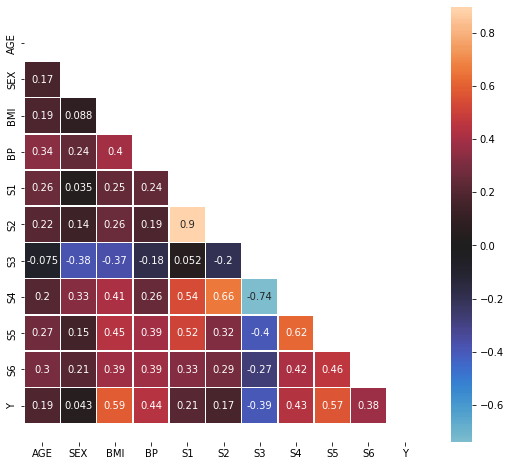

In [5]:
corrs = df.corr() # calculate the correlation table
# as this is a symmetric table, set up a mask so that we only plot values below the main diagonal
mask = np.triu(np.ones_like(corrs, dtype=bool)) 
f, ax = plt.subplots(figsize=(10, 8)) # initialise the plots and axes
# plot the correlations as a seaborn heatmap, with a colourbar
sns.heatmap(corrs, mask=mask, center=0, annot=True, square=True, linewidths=.5) 
# do some fiddling so that the top and bottom are not obscured
bottom, top = ax.get_ylim() 
ax.set_ylim(bottom + 0.5, top - 0.5);

### Multivariate Linear Regression

To carry out regression modelling we now create a matrix of independent variables (features) given by `X`, and vector of the dependent or target variable `Y`. Specifically, we are building models of the form:

$$
Y_{pred} = \text{intercept} + c_{\text{age}} \times \text{AGE} + ... + c_{\text{S6}} \times \text{S6}
$$

and fitting the model parameters in order to minimise the cost function:

$$
( Y - Y_{pred} )^\top ( Y - Y_{pred} )
$$

Here $Y$ refers to a vector of observed target values.

In [6]:
X = df.drop(['Y'],axis=1)  # Create a Dataframe without the target variable Y.
Y = df['Y']                # Extract a Series of the target Y values.

Now we split the data into training and testing sets, and model the data using the  `sklearn` Linear Regression model. All supervised modelling methods (those with input features and output targets) follow the same key steps process in `sklearn`:

1. Split data into training and testing subsets
2. Instantiate a model type (with parameters)
3. Fit model parameters to the training data
4. Evaluate model performance on the testing data

Take note of steps 3. and 4., we fit the model to the training data, however we test its performance on the testing data! Testing on the training data is not particularly informative as the model has been trained on this data in the first place. Instead, we want to assess the performance of the model on unseen data.

In [7]:
# Split into a training set with 80% of the data, and a testing set as the remainder.
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2,
    random_state=np.random.RandomState(31287)  # Keeps the 'random' split consistent.
) 

# Construct and fit the model
linear = LinearRegression()  # Instantatiate the linear regression model
linear.fit(X_train,Y_train)  # Fit the model parameters to the training data.

# Evaluate model performance.
training_predictions = linear.predict(X_train)  # Get model predictions for both.
testing_predictions = linear.predict(X_test)    # training and testing data.

# Create a table of the various scores.
pd.DataFrame({
    "R^2": {
        "train": r2_score(Y_train, training_predictions),
        "test": r2_score(Y_test, testing_predictions)
    },
    "RMSE": {
        "train": mean_squared_error(Y_train, training_predictions, squared=False),
        "test": mean_squared_error(Y_test, testing_predictions, squared=False),
    },
    "MAE": {
        "train": mean_absolute_error(Y_train, training_predictions),
        "test": mean_absolute_error(Y_test, testing_predictions),
    },
})

,R^2,RMSE,MAE
train,0.530166,52.401516,42.455019
test,0.448469,58.108433,46.979149


We have three error scores here:

* $R^2$ is a 'goodness-of-fit' measure between 0 and 1,
* RMSE, the measure which linear regression aims to minimise, and
* MAE, similarly an error metric we want to minimise

Based on the $R^2$ scores we can see that the overall fit is not very good. Prediction error is quite high, being equivalent to about half a standard deviation in the target `Y` variable.

We can also see that the error measures vary quite significantly between the training and testing sets. Some variation is expected (we will always see lower $R^2$ and higher error on testing compared to training sets), but significant variation may indicate that the model is **overfitted** to the training data, and does not **generalise** well to the testing data.

### Analysis of Coefficients

We can investigate the model coefficients to get an idea of the importance of each independent variable in predicting `Y`. However, we cannot directly compare coefficients as their dimensions are different. For example, the `AGE` coefficient will be inversely proportional to years, while the `BP` coefficient will be inversely proportional to mm of Hg. Hence to compare the coefficients we need to make them dimensionless and we also need to know the variability of each of the independent variables.

In [8]:
feature_names = X.columns.tolist() # write the column names to a list

# create a Series for which the rows are the feature names and the data is 
# the regression coefficient values
coefficients = pd.Series(data=linear.coef_.transpose(), index=feature_names)
coefficients

AGE    -0.097335
SEX   -21.440288
BMI     5.610960
BP      1.064001
S1     -1.404878
S2      1.009480
S3      0.545546
S4      4.973988
S5     80.914202
S6      0.152322
dtype: float64

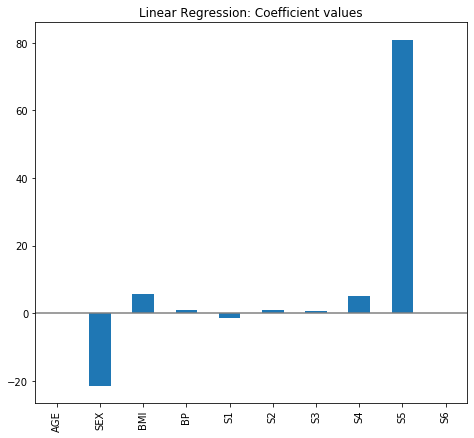

In [9]:
coefficients.plot(kind='bar', figsize=(10, 7)) # plot these as a bar plot
plt.title('Linear Regression: Coefficient values') # add a title
plt.axhline(y=0, color='.5') # add the reference line y = 0
plt.subplots_adjust(left=.3) # move to the left a little bit

The variability of the features can be obtained from the standard deviation, which also has the same dimensions as the original variables. We can see a roughly inverse relationship between the coefficients and the standard deviation, i.e., as one goes up the other goes down.

In [10]:
X_train.std(axis = 0)

AGE    13.083535
SEX     0.499823
BMI     4.432218
BP     13.894686
S1     35.003150
S2     30.579102
S3     13.044317
S4      1.323055
S5      0.533186
S6     11.520394
dtype: float64

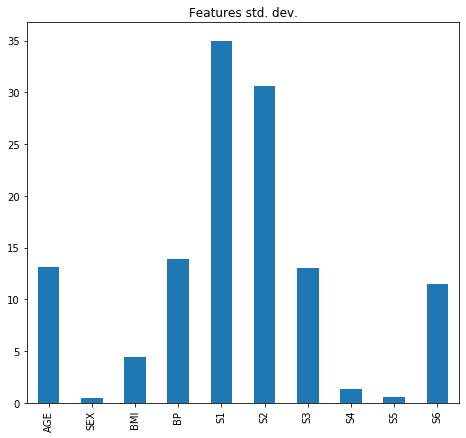

In [11]:
X_train.std(axis=0).plot(kind='bar', figsize=(10, 7)) # plot the standard deviation of the training set features
plt.title('Features std. dev.') # add a title
plt.subplots_adjust(left=.3) # move a bit to the left

The preceding plot suggests that `S1` and `S2` have significant effects on `Y`, which contradicts the conclusions drawn from the corrrelation table earlier. What we haven't yet taken into account is the variability of the coefficients. Thus, the importance of each coefficient can be found by multiplying the coefficient by the standard deviation for each feature. 

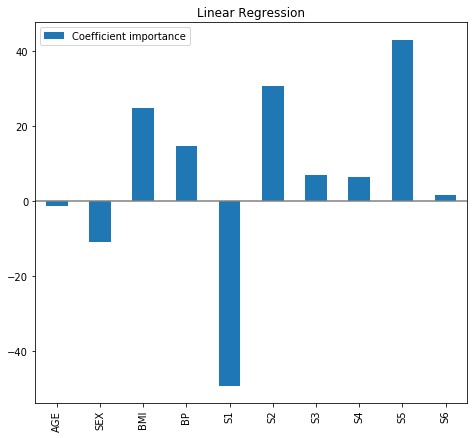

In [12]:
# create a dataframe with the columns being the feature names and regression coefficients multiplied by the 
# standard deviation
coefs = pd.DataFrame(
    linear.coef_ * X_train.std(axis=0),
    columns=['Coefficient importance'], index=feature_names
)
# do a similar plot of this variable, as above
coefs.plot(kind='bar', figsize=(10, 7))
plt.title('Linear Regression')
plt.axhline(y=0, color='.5')
plt.subplots_adjust(left=.3)

### Normalising features

To compare the importance of the coefficients it is easiest to normalise the independent variables from the start. The dependent variable (i.e. target) does not need to be normalised. We normalise all the variables such that their mean is zero and their standard deviation is one, which can be done by subtracting the mean and then dividing by the standard deviation. This is equivalent to multiplying the coefficients by the standard deviation.

In [13]:
nX =(X-X.mean())/X.std() # create nX, a normalised version of X
nX.describe() # show the descriptive statistics of nX

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02
mean,-3.717489e-17,1.321216e-16,-4.609686e-15,-9.625282e-16,-3.174936e-16,8.386956e-16,-1.446806e-16,-1.708035e-16,1.904051e-15,2.364248e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.251738e+00,-9.374744e-01,-1.895781e+00,-2.360375e+00,-2.662394e+00,-2.427874e+00,-2.148448e+00,-1.604285e+00,-2.648040e+00,-2.893112e+00
25%,-7.832846e-01,-9.374744e-01,-7.188104e-01,-7.697777e-01,-7.192046e-01,-6.375263e-01,-7.374604e-01,-8.293610e-01,-6.981574e-01,-6.967595e-01
50%,1.130443e-01,-9.374744e-01,-1.529591e-01,-1.190789e-01,-9.073818e-02,-8.020037e-02,-1.382738e-01,-5.443750e-02,-4.089059e-02,-2.263165e-02
75%,7.995940e-01,1.064282e+00,6.562083e-01,7.485196e-01,5.955183e-01,6.267323e-01,6.155415e-01,7.204860e-01,6.810788e-01,5.862581e-01
max,2.325260e+00,1.064282e+00,3.581660e+00,2.772916e+00,3.232188e+00,4.174548e+00,3.804760e+00,3.889923e+00,2.805543e+00,2.847848e+00


We repeat the linear regression, but now using the normalized variables. While the model parameters will change, there is no change in any of our error measures. This is because the model itself has not really changed: scaling the input features is offset by scaling in the model parameters.

In [14]:
# The below code is identical to our first attempt, the only change is
# substituting nX for X in train_test_split, to use our normalised data.

# Split into a training set with 80% of the data, and a testing set as the remainder.
X_train, X_test, Y_train, Y_test = train_test_split(
    nX, Y, test_size=0.2,
    random_state=np.random.RandomState(31287)  # Keeps the 'random' split consistent.
) 

# Construct and fit the model
linear = LinearRegression()  # Instantatiate the linear regression model
linear.fit(X_train,Y_train)  # Fit the model parameters to the training data.

# Evaluate model performance.
training_predictions = linear.predict(X_train)  # Get model predictions for both.
testing_predictions = linear.predict(X_test)    # training and testing data.

# Create a table of the various scores.
pd.DataFrame({
    "R^2": {
        "train": r2_score(Y_train, training_predictions),
        "test": r2_score(Y_test, testing_predictions)
    },
    "RMSE": {
        "train": mean_squared_error(Y_train, training_predictions, squared=False),
        "test": mean_squared_error(Y_test, testing_predictions, squared=False),
    },
    "MAE": {
        "train": mean_absolute_error(Y_train, training_predictions),
        "test": mean_absolute_error(Y_test, testing_predictions),
    },
})

,R^2,RMSE,MAE
train,0.530166,52.401516,42.455019
test,0.448469,58.108433,46.979149


Again we can plot the linear regression coefficients, but this time we compare them against our original linear regression coefficients to investigate the variability. It can now be seen that the effect of the blood serum measurements (S1 - S6) can have considerable variability.

What we can see here is that the importance of feature S5 was over-inflated when we looked at the coefficients without normalisation, due to its very low variance.

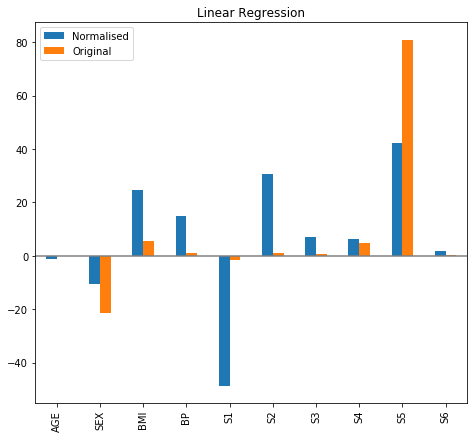

In [15]:
# create a new dataframe with the regression coefficients from the normalised data
normed_coefficients = pd.Series(data=linear.coef_.transpose(), index=feature_names)

# add our original coefficient importance to this dataframe
all_coefficients = pd.DataFrame({
    'Normalised': normed_coefficients,
    'Original': coefficients,
})

# do a similar horizontal plot as before
ax = all_coefficients.plot(kind='bar',figsize=(10,7))
# ax = all_coefficients.plot.bar(figsize = (10, 7))
plt.title('Linear Regression')
plt.axhline(y=0, color='.5')
plt.subplots_adjust(left=.3)

To investigate the variability we can use the `sklearn` methods `cross_validate` and `RepeatedKFold`. The first of these performs a number of runs of a model. The second splits the data in n sections and repeats the calculations m times. This gives n.m runs to investigate the variability of the coefficients. The variability of these can then be plotted using a boxplot.

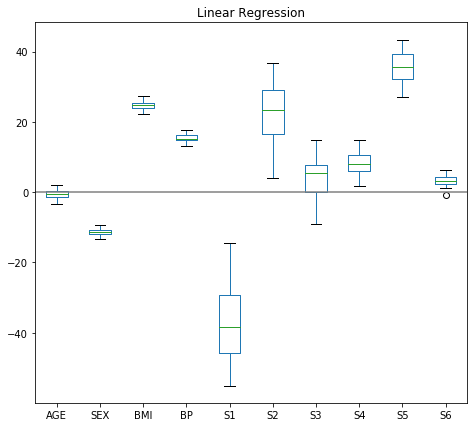

In [16]:
from sklearn.model_selection import cross_validate, RepeatedKFold # import sklearn methods

# cross_validate takes the particular model, in this case linear regression which we instantatiated earlier,
# and undertakes a number of runs according the method specified by cv=
# RepeatedKFold splits the data into n sections and repeat the regression modelling 5 times, giving 25 runs
# return_estimator=True returns the fitting data for each run
scores = cross_validate(
    linear, nX, Y,
    cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=np.random.RandomState(2351786)),
    return_estimator=True,
)
# take the results for each simulation (estimator), extract the coefficients for each run 
# and add them to a dataframe with columns being the feature names
coefs = pd.DataFrame([est.coef_ for est in scores['estimator']],columns=nX.columns)
# plot the descriptive statics of the coefficients in a box and whisker plot to show variability
ax = coefs.plot(kind='box',figsize=(10,7))
plt.title('Linear Regression')
plt.axhline(y=0, color='.5')
plt.subplots_adjust(left=.3)

We can see `AGE`, `SEX`, `BP`, `BMI` and `S6` have very low variance, whereas `S1`-`S5` have high variance. In particular we can see that `AGE` and `S3` do not have a clear effect in the model: in some model fits, they produce a negative coefficient, while in others they produce a positive coefficient. It is therefore not clear whether there is any statistical significance of these parameters in the model.

## Exercises

### Exercise 1

Q: Compare the model coefficients computed in the linear regression with the correlation scores found in the initial data analysis (choose any plot or table which you think is suitable for this comparison). Comment on whether the model fitting results are consistent with the correlation scores.

A: Please find the answer below 

Here are the findings for each feature:

AGE
Correlation with Y: 0.188
Mean Coefficient: -0.499
Observations: There is a discrepancy between the positive correlation and the negative mean coefficient for 'AGE,' showing inconsistency.

SEX
Correlation with Y: 0.043
Mean Coefficient: -11.431
Observations: The correlation is small and positive, while the mean coefficient is significantly negative, showing inconsistency.

BMI
Correlation with Y: 0.586
Mean Coefficient: 24.757
Observations: Both the correlation and mean coefficient indicate a strong positive relationship, showing consistency.

BP
Correlation with Y: 0.441
Mean Coefficient: 15.460
Observations: Both the correlation and mean coefficient suggest a positive relationship, showing consistency.
S1

Correlation with Y: 0.212
Mean Coefficient: -37.032
Observations: There is a discrepancy between the positive correlation and the significantly negative mean coefficient for 'S1,' showing inconsistency.

S2
Correlation with Y: 0.174
Mean Coefficient: 22.222
Observations: Both the correlation and mean coefficient indicate a positive relationship, showing consistency.

S3
Correlation with Y: -0.395
Mean Coefficient: 4.440
Observations: Both the correlation and mean coefficient suggest a negative relationship, showing consistency.

S4
Correlation with Y: 0.430
Mean Coefficient: 8.301
Observations: Both the correlation and mean coefficient suggest a positive relationship, showing consistency.

S5
Correlation with Y: 0.566
Mean Coefficient: 35.507
Observations: Both the correlation and mean coefficient indicate a strong positive relationship, showing consistency.

S6
Correlation with Y: 0.382
Mean Coefficient: 3.241
Observations: Both the correlation and mean coefficient suggest a positive relationship, showing consistency.
In summary, the linear regression model's results match with the correlation scores for certain features. However, inconsistencies exist for other features, where the model coefficients differ from the correlations.

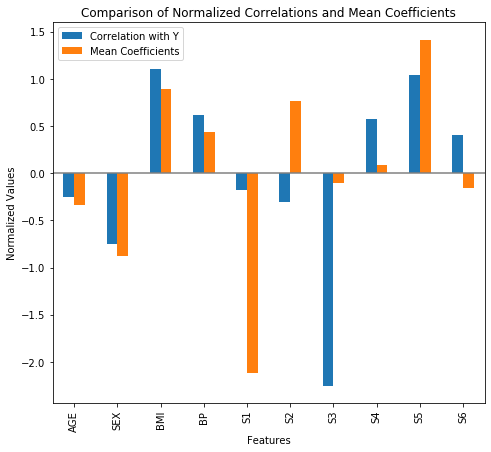

Feature: AGE
Correlation with Y: 0.188
Mean Coefficient: -0.499
------------------------------
Feature: SEX
Correlation with Y: 0.043
Mean Coefficient: -11.431
------------------------------
Feature: BMI
Correlation with Y: 0.586
Mean Coefficient: 24.757
------------------------------
Feature: BP
Correlation with Y: 0.441
Mean Coefficient: 15.460
------------------------------
Feature: S1
Correlation with Y: 0.212
Mean Coefficient: -37.032
------------------------------
Feature: S2
Correlation with Y: 0.174
Mean Coefficient: 22.222
------------------------------
Feature: S3
Correlation with Y: -0.395
Mean Coefficient: 4.440
------------------------------
Feature: S4
Correlation with Y: 0.430
Mean Coefficient: 8.301
------------------------------
Feature: S5
Correlation with Y: 0.566
Mean Coefficient: 35.507
------------------------------
Feature: S6
Correlation with Y: 0.382
Mean Coefficient: 3.241
------------------------------


In [22]:
# Hint 1: Create a dataframe which has the correlations with Y as a column, and then the 
# mean of coefficients computed from the cross_validate method (found in the previous dataframe coefs) for the other column.
# You will need to scale the coefficients in order to compare this with the correlations. 
# Hint 2. Remember you can get correlations by using the method .corr().
# Hint 3: A bar plot seems like a good idea!

# Calculate the correlations between features and the target variable Y
correlations_with_Y = df.corr()['Y'].drop('Y')

# Calculate the mean of coefficients from the cross-validation results and scale them
mean_coefficients = coefs.mean() 

# Normalize the mean coefficients for comparison
mean_coefficients_normalized = (mean_coefficients - mean_coefficients.mean()) / mean_coefficients.std()

# Normalize the correlations for comparison
correlations_normalized = (correlations_with_Y - correlations_with_Y.mean()) / correlations_with_Y.std()

# Create a dataframe to compare normalized correlations and mean coefficients
comparison_df = pd.DataFrame({'Correlation with Y': correlations_normalized, 'Mean Coefficients': mean_coefficients_normalized})

# Plot the comparison
comparison_df.plot(kind='bar', figsize=(10, 7))
plt.title('Comparison of Normalized Correlations and Mean Coefficients')
plt.ylabel('Normalized Values')
plt.xlabel('Features')
plt.axhline(y=0, color='.5')
plt.subplots_adjust(left=.3)
plt.show()


# Calculate the mean of coefficients from the cross-validation results
mean_coefficients = coefs.mean()

# Print correlations and mean coefficients
for feature in correlations_with_Y.index:
    correlation = correlations_with_Y[feature]
    coefficient = mean_coefficients[feature]
    print(f"Feature: {feature}")
    print(f"Correlation with Y: {correlation:.3f}")
    print(f"Mean Coefficient: {coefficient:.3f}")
    print("-" * 30)



### Exercise 2

Q: Try fitting a linear regression model to a subset of the features. To do this, select 3-4 columns from the `nX` dataframe to use when constructing the train-test split, then fit the model parameters to this new training data as before. Describe how you selected your subset of features. Did the model coefficients for your chosen features turn out to be similar or different to those in the full model? (If there is a difference, explain why).

A: We selected the following features based on domain knowledge or analysis: 'BP' (blood pressure), 'BMI' (body mass index), 'S4' (serum measurement 4), and 'S5' (serum measurement 5). These features were chosen as they are commonly associated with health and have shown significant correlations with the target variable 'Y' in previous analyses.
The subset model exhibited  lower R^2 value in comparison, suggesting a reduced ability to explain the variance in the target variable 'Y.' Specifically, the subset model explained 45.8% of the variance in the testing data, which is lower than the full model's performance (around 46.9%).
Differences in the coefficients between the two models is beacause of selective emphasi on specific features within our model which emphasizes the importance of the chosen variables while potentially downplaying the significance of other variables. 

In [18]:
# Select a subset of features (e.g., 'BP', 'BMI', 'S4', 'S5') based on domain knowledge or analysis
subset_features = nX[['BP', 'BMI', 'S4', 'S5']]

# Split the data into training and testing sets using the subset of features
X_train_subset, X_test_subset, Y_train, Y_test = train_test_split(
    subset_features, Y, test_size=0.2,
    random_state=np.random.RandomState(31287)
)

# Fit the linear regression model to the training data
linear_subset = LinearRegression()
linear_subset.fit(X_train_subset, Y_train)

# Evaluate model performance on the testing data
training_predictions_subset = linear_subset.predict(X_train_subset)
testing_predictions_subset = linear_subset.predict(X_test_subset)

# Create a table of the various scores for the subset model
pd.DataFrame({
    "R^2": {
        "train": r2_score(Y_train, training_predictions_subset),
        "test": r2_score(Y_test, testing_predictions_subset)
    },
    "RMSE": {
        "train": mean_squared_error(Y_train, training_predictions_subset, squared=False),
        "test": mean_squared_error(Y_test, testing_predictions_subset, squared=False),
    },
    "MAE": {
        "train": mean_absolute_error(Y_train, training_predictions_subset),
        "test": mean_absolute_error(Y_test, testing_predictions_subset),
    },
})


,R^2,RMSE,MAE
train,0.483519,54.941299,45.274642
test,0.458139,57.596763,48.385362


### Exercise 3 (Bonus!)

Q: Repeat the k-fold cross-validation test for coefficient variability, but first remove the feature 'S2' from the dataset. Observe the impact on the coefficients for the other features. In particular, look at the coefficient for 'S1'. You should see that the range of values produced for the S1 coefficient is much narrower. Can you think of a reason why this is the case (consider the mathematical form of the model)?

A: Removing 'S2' from our linear regression model helped  narrow the range of values of'S1' coefficient and making it more reliable. This was due to the removal of potential variablity between 'S1' and 'S2,' simplifying the model and emphasizing the importance of considering feature interactions in understanding coefficient variability in linear regression.

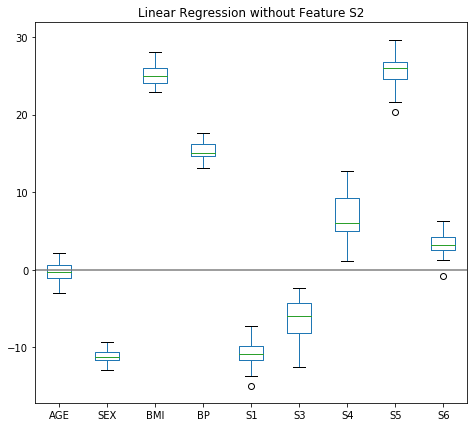

In [20]:
# This task is worth 2 bonus marks.
# Remove 'S2' from the dataset
nX_no_S2 = nX.drop('S2', axis=1)

# Perform k-fold cross-validation on the dataset without 'S2'
scores_no_S2 = cross_validate(
    linear, nX_no_S2, Y,
    cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=np.random.RandomState(2351786)),
    return_estimator=True,
)

# Extract the coefficients for each run without 'S2' and add them to a dataframe
coefs_no_S2 = pd.DataFrame([est.coef_ for est in scores_no_S2['estimator']], columns=nX_no_S2.columns)

# Plot the descriptive statistics of the coefficients without 'S2'
ax = coefs_no_S2.plot(kind='box', figsize=(10, 7))
plt.title('Linear Regression without Feature S2')
plt.axhline(y=0, color='.5')
plt.subplots_adjust(left=.3)
plt.show()
